In [1]:
import torch
import torch.nn as nn
import tiktoken

In [2]:
from gpt_model import *

In [3]:
# to make training faster on a laptop, change context_length as shown:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256,  # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

In [5]:
model = GPTModel(GPT_CONFIG_124M)

In [6]:
start_context = "Every effort moves you"

In [7]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Magical physicist AttributionÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ sketchesbeenroughunctureKEYaned


In [8]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you forward",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [9]:
with torch.no_grad():
    logits = model(inputs)

probs = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probs.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [10]:
probs

tensor([[[1.4987e-05, 2.5454e-05, 1.8972e-05,  ..., 6.6857e-06,
          1.1202e-05, 1.2687e-05],
         [2.3594e-05, 1.5475e-05, 3.8714e-05,  ..., 7.8224e-06,
          1.5605e-05, 9.0045e-06],
         [2.4167e-05, 1.7438e-05, 4.9356e-05,  ..., 3.4949e-05,
          1.4113e-05, 1.4872e-05]],

        [[1.1661e-05, 4.5103e-05, 4.5678e-05,  ..., 7.7209e-06,
          6.4411e-06, 1.0182e-05],
         [2.5758e-05, 3.1875e-05, 2.2354e-05,  ..., 1.2024e-05,
          1.4817e-05, 1.5663e-05],
         [1.5000e-05, 2.6626e-05, 6.5054e-05,  ..., 1.8256e-05,
          1.1593e-05, 2.7085e-05]]])

In [11]:
# predicted tokens:
token_ids = torch.argmax(probs, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[26711],
         [ 6557],
         [46612]],

        [[34487],
         [13791],
         [33070]]])


In [12]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  prostateá waiter


In [13]:
print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Targets batch 2:  really like chocolate
Outputs batch 2: Pri grey cram


In [14]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [15]:
text_idx = 0
target_probs_1 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probs_1)

text_idx = 1
target_probs_2 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probs_2)

Text 1: tensor([2.1299e-05, 1.7519e-05, 1.5568e-05])
Text 2: tensor([2.0574e-05, 1.8915e-05, 1.0504e-05])


In [16]:
torch.set_printoptions( sci_mode=False )

In [17]:
# Compute logarithm of all token probabilities
log_probs = torch.log(torch.cat((target_probs_1, target_probs_2)))
print(log_probs)

tensor([-10.7568, -10.9522, -11.0703, -10.7915, -10.8755, -11.4638])


In [18]:
avg_log_probs = torch.mean(log_probs)
print(avg_log_probs)
neg_avg_log_probs = avg_log_probs * -1
print(neg_avg_log_probs)

tensor(-10.9850)
tensor(10.9850)


In [19]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [20]:
print(logits_flat)
print(targets_flat)

tensor([[-0.1166,  0.4131,  0.1192,  ..., -0.9238, -0.4077, -0.2832],
        [ 0.3386, -0.0832,  0.8338,  ..., -0.7654, -0.0748, -0.6247],
        [ 0.3640,  0.0377,  1.0781,  ...,  0.7329, -0.1739, -0.1215],
        [-0.3704,  0.9823,  0.9950,  ..., -0.7827, -0.9639, -0.5060],
        [ 0.4205,  0.6336,  0.2788,  ..., -0.3413, -0.1324, -0.0769],
        [-0.1156,  0.4582,  1.3515,  ...,  0.0808, -0.3733,  0.4753]])
tensor([ 3626,  6100,   345,  1107,   588, 11311])


In [21]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.9850)


In [22]:
# a more interpretable version of cross entropy --
# this is basically the number of tokens the model considers for predicted output
perplexity = torch.exp(loss)
print(perplexity)

tensor(58984.5117)


In [23]:
# use the short story from before for training:
with open( "humphreys.txt", "r" ) as f:
    text_data = f.read()
print(text_data[:100])

ABOUT fifteen years ago, on a date late in August or early in September, a train drew up at Wilsthor


In [24]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [25]:
# separate text into training and validation sets:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [26]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 12800
Validation tokens: 1280
All tokens: 14080


In [27]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cpu device.
Training loss: 10.98396583557129
Validation loss: 10.992756207784018


In [29]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [30]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 9.712, Val loss 9.801
Ep 1 (Step 000005): Train loss 8.146, Val loss 8.248
Ep 1 (Step 000010): Train loss 6.962, Val loss 7.228
Ep 1 (Step 000015): Train loss 6.521, Val loss 6.878
Ep 1 (Step 000020): Train loss 6.037, Val loss 6.749
Every effort moves you of the’, and the’, and the’, and the’, and thereys, and the of the of the of the of the’, and the of the of the of the of the of the of
Ep 2 (Step 000025): Train loss 6.083, Val loss 6.643
Ep 2 (Step 000030): Train loss 5.643, Val loss 6.565
Ep 2 (Step 000035): Train loss 5.551, Val loss 6.543
Ep 2 (Step 000040): Train loss 5.551, Val loss 6.542
Ep 2 (Step 000045): Train loss 5.021, Val loss 6.468
Every effort moves you’s the.’s the house, and I'm.’s the house, and the house, and that, and a maze.’s the house, and the house, and I'm of that, and that
Ep 3 (Step 000050): Train loss 5.004, Val loss 6.350
Ep 3 (Step 000055): Train loss 4.592, Val loss 6.401
Ep 3 (Step 000060): Train loss 4.604, Val loss 6.

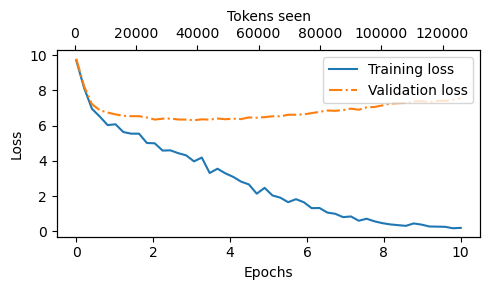

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [32]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you know———and, turning from it, addressed himself to his plan. After half an hour's work he found it was


In [33]:
# read the book for more details and examples!
# temperature scaling and top-k sampling together increase 
# the diversity of predictions

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [36]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you see it just at a great portion of Cooper arrived at last? Oh:
